# Visualization of a Simple Stochastic Gradient Descent (TensorFlow-2.0)

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla SGD, batch SGD and minibatch SGD. For this we consider a linear model with only one weight and one bias (the slope and the offset).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.version.VERSION

'2.0.0-beta1'

In TensorFlow-2.0, Eager Execution is enabled by default

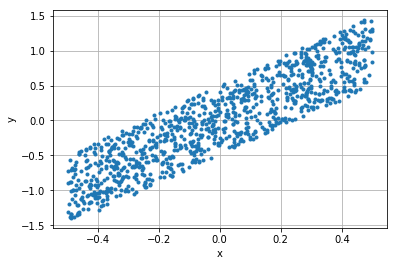

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

### 1. Create a dataset object and define an input pipeline with the `tf.data` API.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1000)
dataset = dataset.repeat(100)

### 2. Define the model

Here we define again a linear model using Keras' `Sequential`. For that we have to use linear activation.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,), activation='linear'),
])

opt = tf.keras.optimizers.SGD(lr=0.5)

model.compile(optimizer=opt,
              loss='mse')

The following is not really part of the train. It's just a callback to save the training history for plotting. Callbacks a very important in Keras, as they enable the customization of the training.

In [6]:
class TrainHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.vars = []
        self.loss = []

    def on_batch_end(self, batch, logs={}):
        self.vars.append([v.numpy() for v in self.model.variables])
        self.loss.append(logs.get('loss'))

### 3. Training

In [7]:
history = TrainHistory()
fit = model.fit(dataset, callbacks=[history])

100/100 [==============================] - 1s 7ms/step - loss: 0.0896


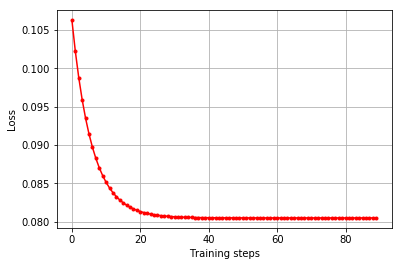

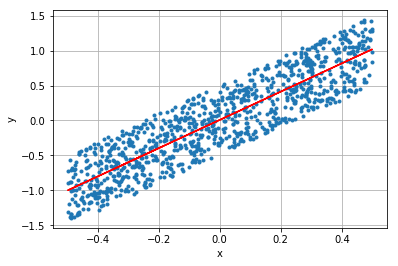

In [8]:
slope_hist = np.array(history.vars)[:, 0]
offset_hist = np.array(history.vars)[:, 1]
loss_hist = np.array(history.loss)

plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

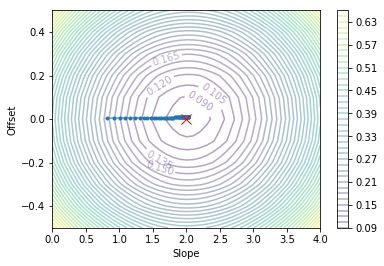

In [9]:
def loss_function_field(m, n, xref, yref):
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)
        
#matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

cp = plt.contour(M, N, Z, 50, vmin=Z.min(), vmax=Z.max(), alpha=0.4)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=1)
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

#matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)